In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import os 
from tqdm import tqdm
import matplotlib.pyplot as plt 

import time
import random
from scipy.stats import norm
import numpy as np


device = "cuda"

In [2]:
#!pip install torch --upgrade
print(torch.__version__)
torch.cuda.is_available()


2.1.0+cu121


True

In [3]:
# MNIST Dataset을 사용

bs = 100 # batch size

# MNIST Dataset
train_dataset = datasets.MNIST(root='./Datasets/mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./Datasets/mnist_data/', train=False, transform=transforms.ToTensor(), download=True)

# Data Loader (Input Pipeline)
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)



## VAE

In [4]:
# Define Model
class VAE(nn.Module):
    def __init__(self, imgChannels=1, featureDim=64*14*14, zDim=2):
        super(VAE, self).__init__()

        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(imgChannels, 32, 3, padding = 1)
        self.encConv2 = nn.Conv2d(32, 64, 3, stride = 2, padding = 1)
        self.encConv3 = nn.Conv2d(64, 64, 3, padding = 1)
        self.encConv4 = nn.Conv2d(64, 64, 3, padding = 1)
        self.encFC0 = nn.Linear(featureDim, 32)
        self.encFC1 = nn.Linear(32, zDim)
        self.encFC2 = nn.Linear(32, zDim)

        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
        self.decConv1 = nn.ConvTranspose2d(64, 32, 3, stride = 2, padding=1, output_padding = 1)
        self.decConv2 = nn.Conv2d(32, 1, 3, padding = 1)

    def encoder(self, x):

        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = F.relu(self.encConv1(x))
        x = F.relu(self.encConv2(x))
        x = F.relu(self.encConv3(x))
        x = F.relu(self.encConv4(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.encFC0(x))
        mu = self.encFC1(x)
        logVar = self.encFC2(x)
        return mu, logVar

    def reparameterize(self, mu, logVar):

        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decoder(self, z):

        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = F.relu(self.decFC1(z))
        x = x.view(-1, 64, 14, 14)
        x = F.relu(self.decConv1(x))
        x = torch.sigmoid(self.decConv2(x))
        return x

    def forward(self, x):
        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar


In [5]:
model = VAE() 
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

In [6]:
def train(dataloader):
    model.train()
    
    loss_record = 0
    total = 0
    
    for datas, labels in tqdm(dataloader):
        datas, labels = datas.to(device), labels.to(device)
        total += datas.size(0)
        
        optimizer.zero_grad() 
        
        recons, mu, log_var  = model(datas)
        
        recons_loss = F.mse_loss(recons, datas)
        kld_loss = torch.mean(-5e-4 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
        loss = recons_loss + kld_loss
        loss_record += loss.item()
        
        loss.backward()  
        optimizer.step()  
    return loss_record / len(dataloader)

def val_test(dataloader):
    model.eval()
    
    loss_record = 0
    total = 0
    
    with torch.no_grad():
        for datas, labels in tqdm(dataloader):
            datas, labels = datas.to(device), labels.to(device)
            total += datas.size(0)

            recons, mu, log_var  = model(datas)

            recons_loss = F.mse_loss(recons, datas)
            kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
            loss = recons_loss + kld_loss
            loss_record += loss.item()

    return loss_record / len(dataloader)

======================== Epoch 0 ========================


100%|██████████| 100/100 [00:01<00:00, 67.09it/s]


Train_loss :  0.06793291573723158
Val_loss :  3.4199067616462706


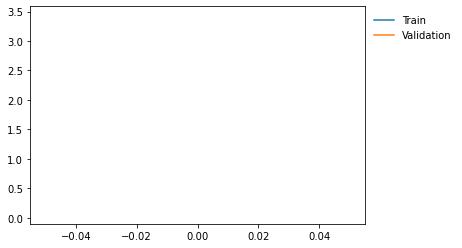

======================== Epoch 1 ========================


100%|██████████| 100/100 [00:01<00:00, 65.69it/s]


Train_loss :  0.052573752949635184
Val_loss :  4.156666076183319


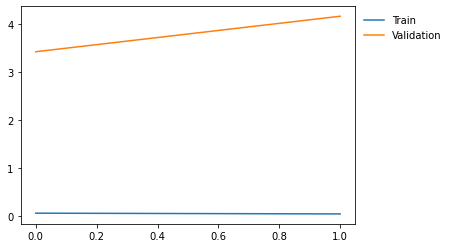

======================== Epoch 2 ========================


100%|██████████| 100/100 [00:01<00:00, 67.23it/s]


Train_loss :  0.04953951464345058
Val_loss :  4.7521335935592655


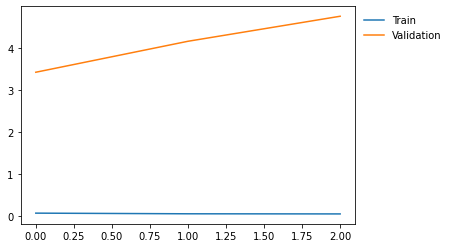

======================== Epoch 3 ========================


100%|██████████| 100/100 [00:01<00:00, 66.36it/s]


Train_loss :  0.04844125374530753
Val_loss :  4.827041258811951


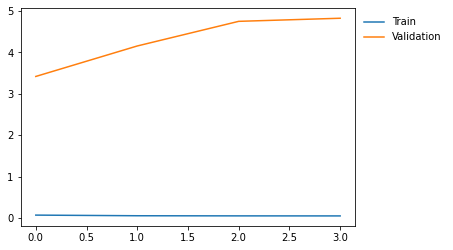

======================== Epoch 4 ========================


100%|██████████| 100/100 [00:01<00:00, 66.51it/s]


Train_loss :  0.04769722332557042
Val_loss :  4.734239912033081


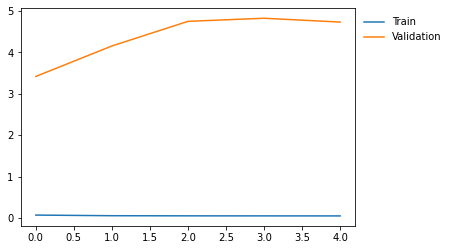

In [7]:
# train

train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

for epoch in range(0, 5):    
    print("======================== Epoch " + str(epoch) + " ========================")
    
    train_loss = train(train_dataloader)
    train_loss_list.append(train_loss)

    val_loss = val_test(val_dataloader)
    val_loss_list.append(val_loss)
    
    print("Train_loss : ", train_loss) 
    print("Val_loss : ", val_loss)

    plt.plot(list(range(len(train_loss_list))), train_loss_list, label = "Train")
    plt.plot(list(range(len(val_loss_list))), val_loss_list, label = "Validation")
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0),fontsize = 10,frameon=False)
    plt.show()

In [8]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

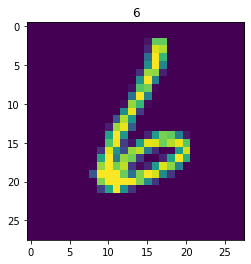

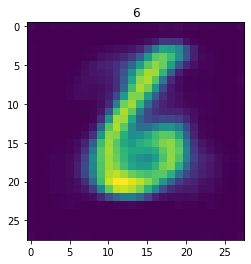

In [9]:
# visualize reconstruction

for data in random.sample(list(train_dataloader), 1):
    imgs, labels = data
    out, mu, logVAR = model(imgs.to(device))
    break

plt.figure()
imshow(imgs[0], title=str(labels[0].item()))

plt.figure()
imshow(out[0], title=str(labels[0].item()))   

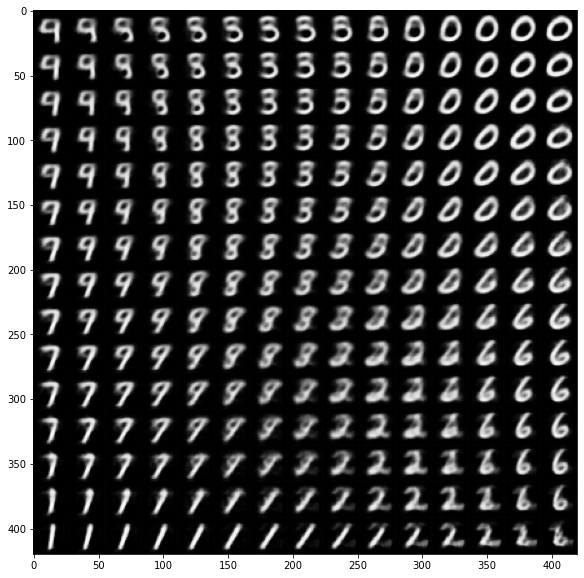

In [12]:

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, 100).reshape(100, 2)
        x_decoded = model.decoder(torch.tensor(z_sample).to(device).float())
        digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

## GAN

In [13]:
# Define models G and D

latent_dim = 100 

# 생성자(Generator) 클래스 정의
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # 하나의 블록(block) 정의
        def block(input_dim, output_dim, normalize=True):
            layers = [nn.Linear(input_dim, output_dim)]
            if normalize:
                # 배치 정규화(batch normalization) 수행(차원 동일)
                layers.append(nn.BatchNorm1d(output_dim, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        # 생성자 모델은 연속적인 여러 개의 블록을 가짐
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 3 * 32 * 32), 
            nn.Tanh() 
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 3, 32, 32)
        return img
 
 
# 판별자(Discriminator) 클래스 정의  
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(3 * 32 * 32, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        flattened = img.view(img.size(0), -1)
        output = self.model(flattened)

        return output

In [14]:
# CIFAR-10 Dataset을 사용

transforms_train = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),  
])
height = 32
width = 32
channels = 3
train_dataset = datasets.CIFAR10(root="./dataset", train=True, download=True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

Files already downloaded and verified


In [15]:
# 생성자(generator)와 판별자(discriminator) 초기화
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

# 손실 함수(loss function)
adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()

lr = 0.0002

optimizer_G = torch.optim.Adam(generator.parameters(),lr=lr,betas=(0.5,0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(),lr=lr,betas=(0.5,0.999))

In [16]:

os.makedirs("GAN_IMAGE", exist_ok=True)

n_epochs = 50
sample_interval = 2000 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0)
        fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0) 

        real_imgs = imgs.cuda()

        # 생성자를 학습
        optimizer_G.zero_grad()

        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()

        # 이미지 생성
        generated_imgs = generator(z)

        g_loss = adversarial_loss(discriminator(generated_imgs), real)

        # 생성자 업데이트
        g_loss.backward()
        optimizer_G.step()

        # 판별자를 학습
        optimizer_D.zero_grad()

        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 판별자 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            save_image(generated_imgs.data[:25], f"./GAN_IMAGE/{done}.png", nrow=5, normalize=True)
    if epoch % 5 == 0:
        print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}][Elapsed time: {time.time() - start_time:.2f}s]")

/tmp/ipykernel_18142/55548847.py:10: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0)


[Epoch 0/50] [D loss: 0.415115] [G loss: 1.351182][Elapsed time: 8.43s]
[Epoch 5/50] [D loss: 0.437819] [G loss: 1.467874][Elapsed time: 47.22s]
[Epoch 10/50] [D loss: 0.489422] [G loss: 1.446407][Elapsed time: 86.19s]
[Epoch 15/50] [D loss: 0.586411] [G loss: 1.217225][Elapsed time: 125.79s]
[Epoch 20/50] [D loss: 0.544684] [G loss: 1.057826][Elapsed time: 164.66s]
[Epoch 25/50] [D loss: 0.485903] [G loss: 1.057992][Elapsed time: 203.33s]
[Epoch 30/50] [D loss: 0.582961] [G loss: 1.133887][Elapsed time: 241.84s]
[Epoch 35/50] [D loss: 0.477806] [G loss: 1.254263][Elapsed time: 281.20s]
[Epoch 40/50] [D loss: 0.567781] [G loss: 1.088906][Elapsed time: 319.99s]
[Epoch 45/50] [D loss: 0.600524] [G loss: 1.039114][Elapsed time: 358.82s]


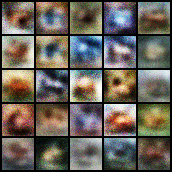

In [17]:
from IPython.display import Image
Image('./GAN_IMAGE/10000.png')

# Additional Experiments

* 모델 아키텍처 변경: 
인코더 및 디코더의 층 수 및 뉴런 수를 변경, 
다른 종류의 층, 예를 들면 LSTM이나 GRU와 같은 순환 층을 추가,
디코더에 층을 추가하여 더 복잡한 생성 모델을 만들기

* 잠재 표현 분석:
잠재 표현을 시각화하고 분석, 특정 차원이 어떤 의미를 가지고 있는지 확인, 특정 차원을 변화시키면 어떻게 이미지가 변하는지 살펴보기, 잠재 공간에서의 보간 및 조작 실험을 수행

* 하이퍼파라미터 튜닝

* GAN과의 결합:
Conditional VAE 또는 Variational Autoencoder with Adversarial Networks(VAE-GAN)과 같은 변형된 버전을 시도

## Adversarial Autoencoder (AAE)

* Autoencoder와 Generative Adversarial Network (GAN)을 결합한 모델
* AAE는 데이터의 특징을 추출하는 자동 인코더의 아이디어를 기반으로 하되, 생성된 데이터가 실제 데이터와 구별하기 어렵게 만드는 GAN의 아이디어도 포함
* 학습 데이터 사이즈가 너무 크고, 학습에 시간이 많이 걸려 코드만 작성

In [18]:
import time
import torch
from torch import nn, cuda, device, optim
import torchvision as tv
from torch.autograd import Variable
from torchsummary import summary

from matplotlib import pyplot as plt

print(cuda.is_available())
device = device('cuda:0')
print(device)

True
cuda:0


In [19]:
class Encoder(nn.Module):
    def __init__(self, nc, nf, nz):
        super(Encoder, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(nc, nf, 5, 2, 2, bias=False),
            nn.BatchNorm2d(nf),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(nf, nf*2, 5, 2, 2, bias=False),
            nn.BatchNorm2d(nf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(nf*2, nf*4, 5, 2, 2, bias=False),
            nn.BatchNorm2d(nf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(in_features=4*4*nf*4, out_features=1024),
            nn.BatchNorm1d(num_features=1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.mu = nn.Linear(in_features=1024, out_features=nz)
        #self.var = nn.Linear(in_features=1024, out_features=nz)

    def forward(self, input):
        y =  self.net(input)
        return self.mu(y)#, self.var(y)

In [20]:
enc = Encoder(nc=3, nf=32, nz=128).to(device)
summary(enc, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]           2,400
       BatchNorm2d-2           [-1, 32, 16, 16]              64
         LeakyReLU-3           [-1, 32, 16, 16]               0
            Conv2d-4             [-1, 64, 8, 8]          51,200
       BatchNorm2d-5             [-1, 64, 8, 8]             128
         LeakyReLU-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 4, 4]         204,800
       BatchNorm2d-8            [-1, 128, 4, 4]             256
         LeakyReLU-9            [-1, 128, 4, 4]               0
          Flatten-10                 [-1, 2048]               0
           Linear-11                 [-1, 1024]       2,098,176
      BatchNorm1d-12                 [-1, 1024]           2,048
        LeakyReLU-13                 [-1, 1024]               0
           Linear-14                  [

In [21]:
class Unflatten(nn.Module):
    def __init__(self, shape):
        super(Unflatten, self).__init__()
        self.shape = shape
        
    def forward(self, input):
        return input.view(len(input), self.shape[0], self.shape[1], self.shape[2])
    
class Decoder(nn.Module):
    def __init__(self, nc, nz, nf):
        super(Decoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features=nz, out_features=4*4*nf*4),
            nn.BatchNorm1d(num_features=4*4*nf*4),
            nn.LeakyReLU(0.2, inplace=True),
            Unflatten((128, 4, 4)),
            
            # add output_padding=1 to ConvTranspose2d to reconstruct original size
            nn.ConvTranspose2d(nf*4, nf*2, 5, 2, 2, 1, bias=False),
            nn.BatchNorm2d(nf*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(nf*2, nf, 5, 2, 2, 1, bias=False),
            nn.BatchNorm2d(nf),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(nf, int(nf/2), 5, 2, 2, 1, bias=False),
            nn.BatchNorm2d(int(nf/2)),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(int(nf/2), nc, 5, 1, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, input):
        return self.net(input)

In [22]:
class Discriminator(nn.Module):
    def __init__(self, nc, nz, nf):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(nz, 1000),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1000, 1000),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1000, 1),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.net(input)

In [23]:
dec = Decoder(nc=3, nz=128, nf=32).to(device)
dis = Discriminator(nc=3, nz=128, nf=32).to(device)

summary(dis, (1, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1000]         129,000
         LeakyReLU-2              [-1, 1, 1000]               0
            Linear-3              [-1, 1, 1000]       1,001,000
         LeakyReLU-4              [-1, 1, 1000]               0
            Linear-5                 [-1, 1, 1]           1,001
           Sigmoid-6                 [-1, 1, 1]               0
Total params: 1,131,001
Trainable params: 1,131,001
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 4.31
Estimated Total Size (MB): 4.35
----------------------------------------------------------------


In [ ]:
batch_size = 128
image_size = 32
dataroot = './img_align_celeba.zip/'
transform = tv.transforms.Compose([tv.transforms.Resize(image_size),
                                tv.transforms.CenterCrop(image_size),
                                tv.transforms.ToTensor(),
                                tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = tv.datasets.ImageFolder(root=dataroot, transform = transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=8, drop_last=True)
print(len(dataloader))

nz = 128
enc = Encoder(nc=3, nf=32, nz=nz).to(device)
dec = Decoder(nc=3, nz=nz, nf=32).to(device)
dis = Discriminator(nc=3, nz=nz, nf=32).to(device)

beta = 0.5
optimizer_dis = optim.Adam(dis.parameters(), lr=1e-3, betas=(beta, 0.999))
optimizer_dec = optim.Adam(dec.parameters(), lr=1e-3, betas=(beta, 0.999))
optimizer_enc = optim.Adam(enc.parameters(), lr=1e-3, betas=(beta, 0.999))

criterion_gan = nn.BCELoss()
criterion_rec = nn.MSELoss(reduction='mean')
criterion_l1 = nn.L1Loss()

In [ ]:
enc_losses = []
dec_losses = []
dis_losses = []

epochs = 50
for epoch in range(1, epochs + 1):
    start = time.time()
    for idx, (data, _) in enumerate(dataloader):
        #if idx == 1: break
        batch_size = data.shape[0]
        
        x = Variable(data).to(device)
        z = enc(x)
        
        #Dis
        z_real = Variable(torch.randn(batch_size, nz).to(device))
        y_real = Variable(torch.ones(batch_size).to(device))
        dis_real_loss = criterion_gan(dis(z_real).view(-1), y_real)
        
        y_fake = Variable(torch.zeros(batch_size).to(device))
        dis_fake_loss = criterion_gan(dis(z).view(-1), y_fake)
        
        dis.zero_grad()
        dis_loss = dis_fake_loss + dis_real_loss
        dis_loss.backward(retain_graph=True)
        optimizer_dis.step()
        dis_losses.append(dis_loss.item())
        
        #Enc 
        y_real = Variable(torch.ones(batch_size).to(device))
        enc_gan_loss = criterion_gan(dis(z).view(-1), y_real)
        
        enc_loss = enc_gan_loss
        
        enc.zero_grad()
        enc_loss.backward(retain_graph=True)
        optimizer_enc.step()
        enc_losses.append(enc_loss.item())
        
        #Dec
        rec = dec(z)
        dec_rec_loss = criterion_l1(x, rec)
        
        dec_loss = dec_rec_loss
        dec.zero_grad()
        dec_loss.backward()
        optimizer_dec.step()
        dec_losses.append(dec_loss.item())
        
        if not (idx % len(dataloader)):
            print('[%d/%d;%d/%d]: loss_dis: %.3f, loss_dec: %.3f, loss_enc: %.3f'
              % (idx, len(dataloader),
                 (epoch), epochs, 
                 torch.mean(torch.FloatTensor(dis_losses)), 
                 torch.mean(torch.FloatTensor(dec_losses)), 
                 torch.mean(torch.FloatTensor(enc_losses))))
    print('Time: ', time.time() - start)

In [ ]:
idx, (data, label) = next(enumerate(dataloader))
x = Variable(data).to(device)
plt.figure(figsize=(20,20))
plt.imshow(tv.utils.make_grid(x.detach().cpu(), nrow=16, normalize=True).permute(1, 2, 0))
plt.show()

In [ ]:
z = enc(x)
rec = dec(z)
y = rec.detach().cpu()
plt.figure(figsize=(20,20))
plt.imshow(tv.utils.make_grid(y,  nrow=16, normalize=True).permute(1, 2, 0))
plt.show()

In [ ]:
zp = Variable(torch.randn(batch_size, nz).to(device))
rec1 = dec(zp)
y1 = rec1.detach().cpu()
plt.figure(figsize=(20,20))
plt.imshow(tv.utils.make_grid(y1,  nrow=16, normalize=True).permute(1, 2, 0))
plt.show()

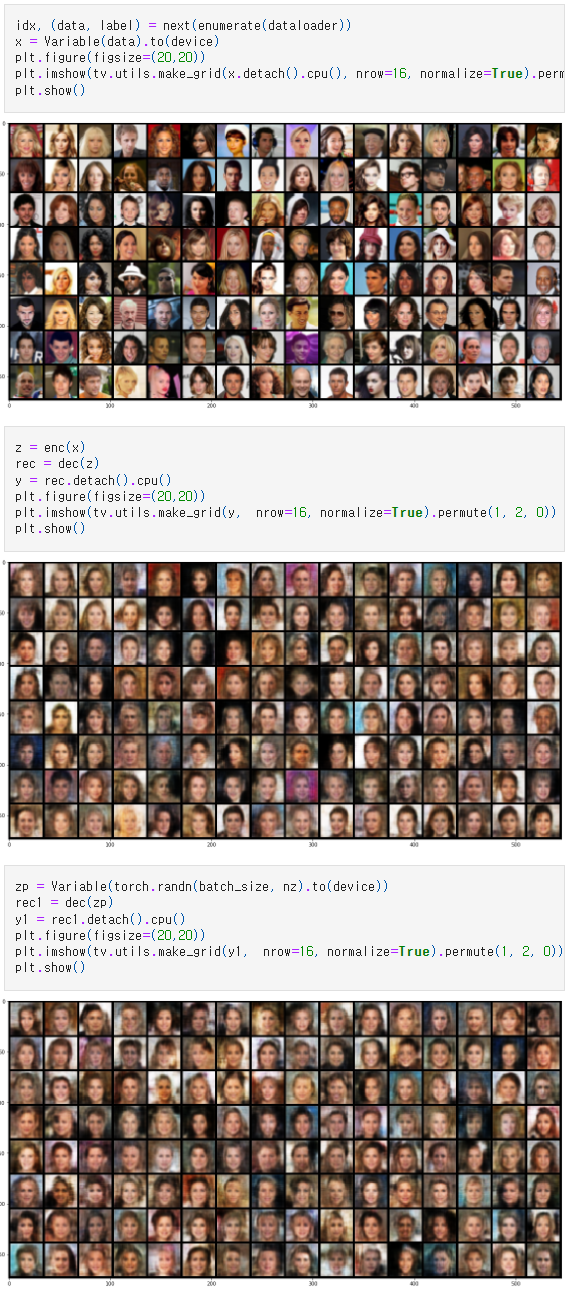

# References

* https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice
* https://github.com/artemsavkin/aae
